## Ejercicio práctico clase 3

Seleccionar el área de interés de las imágenes IR usando los criterios de filtros, selección de bordes y morfología matemática. Compare al menos dos técnicas de forma independiente y secuencial.
Una vez que haya podido elegir el área de interés, úselo como una máscara para aplicar el conjunto de prueba  (testset), donde solo se pueda observar el área de interés y el resto de pixeles estén asignado el valor de 0. 

In [ ]:
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image 
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

images_path = 'C:/documentos/Data'
dataset_path = 'C:/documentos/Dataset'
test_dir = 'C:/documentos/Dataset/test'
train_dir = 'C:/documentos/Dataset/train'


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

images = os.listdir(images_path)

train_images, test_images = train_test_split(images, train_size=0.8, random_state=42) 

for file in train_images:
    shutil.copy2(os.path.join(images_path,file),os.path.join(train_dir,file))
    
for file in test_images:
    shutil.copy2(os.path.join(images_path,file),os.path.join(test_dir,file))
    
print(f"Imagenes en train listas: {len(train_images)}")
print(f"Imagenes en test listas: {len(test_images)}") 

Imagenes en train listas: 277
Imagenes en test listas: 70


In [102]:
def plot_random_images (images_path, num_images):
    images = os.listdir(images_path)
    selected_images = random.sample(images,num_images)
    plt.figure(figsize=(15,5))
    for i, file_name in enumerate (selected_images):
        img_path = os.path.join(images_path,file_name)
        img = Image.open(img_path)
        plt.subplot(1,num_images,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(file_name)
        plt.axis('off')
    plt.show()

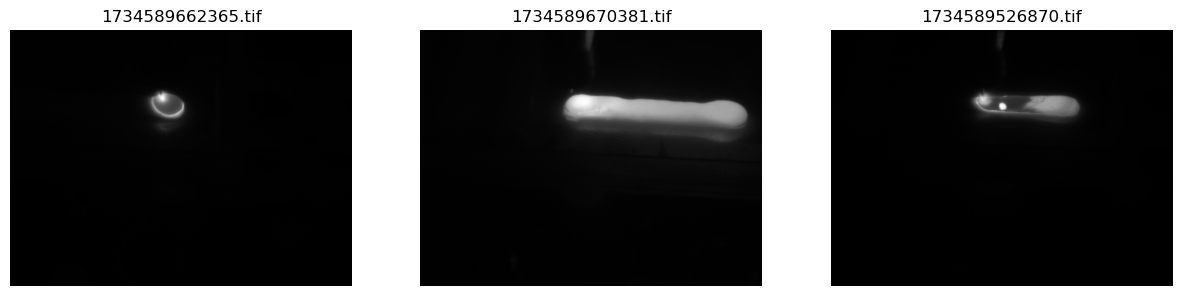

In [80]:
plot_random_images(test_dir,3)

## Entrenamiento K-Means para obtener los Centroides


In [ ]:
images_train = os.listdir(train_dir)
test_images = os.listdir(test_dir)

n_clusters = 6
all_pixels = []

print("Entrenando K-Means con imágenes TIFF de Train...")

for file_name in images_train:
    img_path = os.path.join(train_dir, file_name)
    # Lectura especial para TIFF enseñada por el profesor
    img_tiff = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img_tiff is not None:
        # Normalización a 8-bits para poder procesar
        img_8bit = cv2.normalize(img_tiff, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        # Filtro de suavizado previo
        blur = cv2.GaussianBlur(img_8bit, (5, 5), 0)
        all_pixels.append(blur.flatten())

# Concatenar y aplicar K-Means
pixel_values = np.concatenate(all_pixels).reshape(-1, 1)
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixel_values, n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Ordenar de menor a mayor centroides (el más brillante será nuestra área de interés) el claster 6 será el que tiene mayor iluminación
centers = np.sort(centers.flatten())
print(f"Centroides térmicos obtenidos: {centers}")

Entrenando K-Means con imágenes TIFF de Train...
Centroides térmicos obtenidos: [  1.2582613  17.616951   52.227394   83.334305  124.10715   187.58783  ]


# Pruebas del conjunto de TEST

### Comparativa de la aplicación de 2 técnicas:

TÉCNICA 1: Segmentación K-Means + Morfología

TÉCNICA 2: Filtro + Otsu + Selección de Bordes + Morfología


In [ ]:
def comparar_tecnicas(img_path):
    kernel_pequeno = np.ones((3, 3), np.uint8)
    kernel_grande = np.ones((25, 25), np.uint8)

    img_tiff = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img_tiff is None: return
    img_test = cv2.normalize(img_tiff, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Filtro previo al procesamiento
    img_suavizada = cv2.GaussianBlur(img_test, (5, 5), 0)

    # TÉCNICA 1: Segmentación K-Means + Morfología
    # Clasificar píxeles según el entrenamiento
    pixel_values_test = img_suavizada.astype(np.float32)
    # Así calculamos los LABELS NUEVOS para la foto nueva en el Test:
    distances = np.abs(pixel_values_test[:, :, np.newaxis] - centers)
    labels_test = np.argmin(distances, axis=2)

    # Máscara inicial (aislar el clúster más brillante: n_clusters - 1)
    # Se usa n-1 porque la variable centers se ordenó de menor a mayor, el último cluster  es el más brillante 
    mask_kmeans = np.zeros_like(img_test, dtype=np.uint8)
    # Píxeles de la imagen de prueba que caigan en el grupo del cluster 6(el más claro) les asigno el color blanco(255)
    #mask_kmeans[labels_test == (n_clusters - 1)] = 255
    mask_kmeans[(labels_test == (n_clusters - 1)) | (labels_test == (n_clusters - 2)) ] = 255

    # Morfología: Apertura para limpiar ruido externo, Clausura para rellenar vacíos internos
    mask1 = cv2.morphologyEx(mask_kmeans, cv2.MORPH_OPEN, kernel_pequeno)
    mask1 = cv2.morphologyEx(mask1, cv2.MORPH_CLOSE, kernel_grande)

    # TÉCNICA 2: Filtro + Otsu + Selección de Bordes + Morfología
    # Aplicación de Otsu
    _, thresh_otsu = cv2.threshold(img_suavizada, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Extraer bordes usando el gradiente morfológico
    bordes = cv2.morphologyEx(thresh_otsu, cv2.MORPH_GRADIENT, kernel_pequeno)
    # Sumar los bordes al umbral original para reforzar el contorno y aplicar clausura fuerte
    mask_combinada = cv2.add(thresh_otsu, bordes)
    mask2 = cv2.morphologyEx(mask_combinada, cv2.MORPH_CLOSE, kernel_grande)

    # APLICAR MÁSCARAS (Fondo = 0)
    resultado_T1 = cv2.bitwise_and(img_test, img_test, mask=mask1)
    resultado_T2 = cv2.bitwise_and(img_test, img_test, mask=mask2)

    # GRÁFICOS
    plt.figure(figsize=(16, 8))
    
    plt.subplot(2, 3, 1)
    plt.imshow(img_test, cmap='gray')
    plt.title("Imagen Original Normalizada")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(mask1, cmap='gray')
    plt.title("Téctinca1: Máscara K-Means + Morfología")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(resultado_T1, cmap='inferno')
    plt.title("Téctinca1: Resultado (Fondo = 0)")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(mask2, cmap='gray')
    plt.title("Téctinca2: Máscara Otsu + Bordes + Morf.")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(resultado_T2, cmap='inferno')
    plt.title("Téctinca2: Resultado (Fondo = 0)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

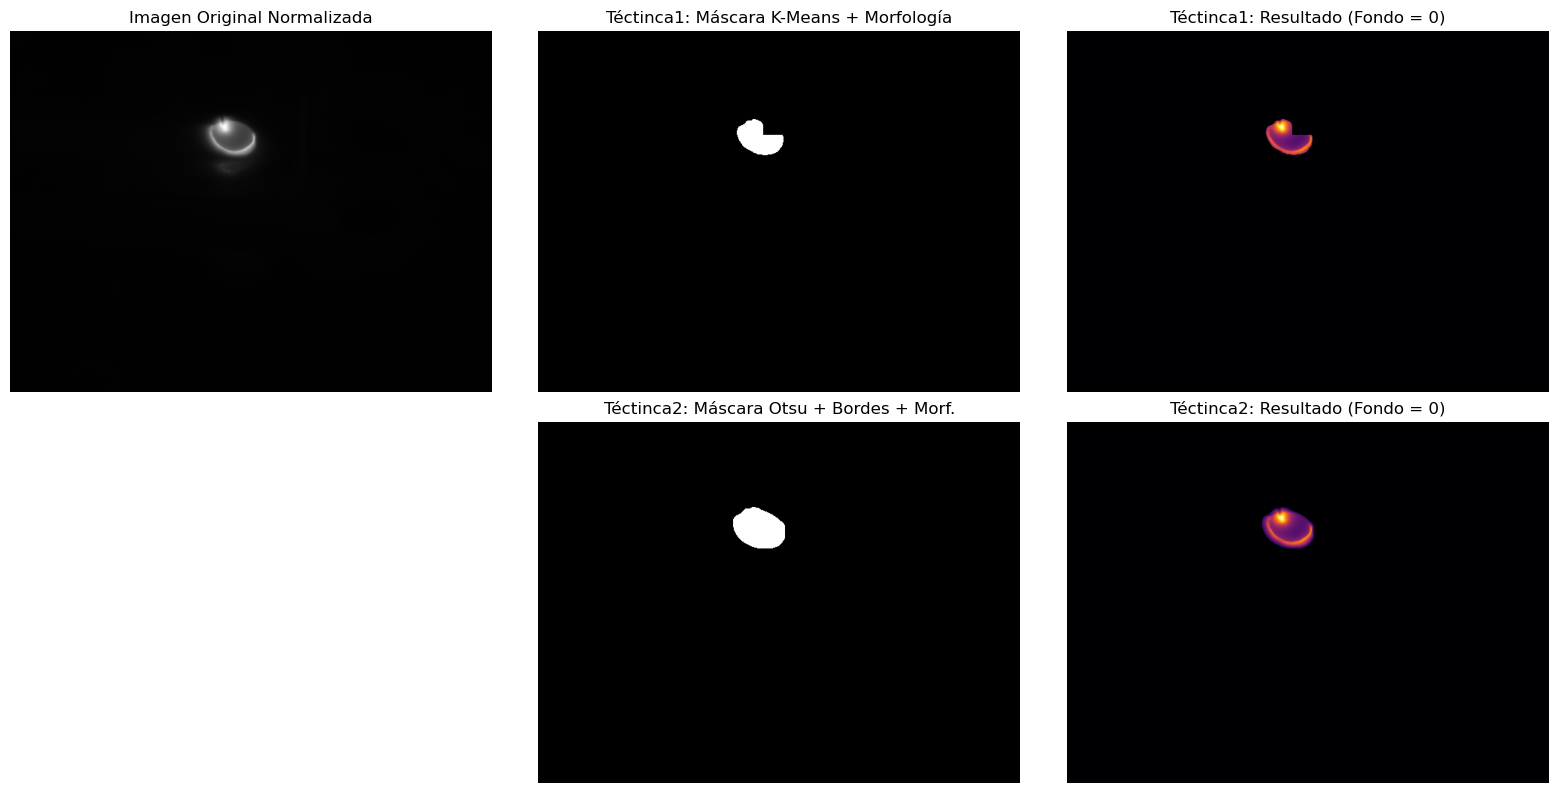

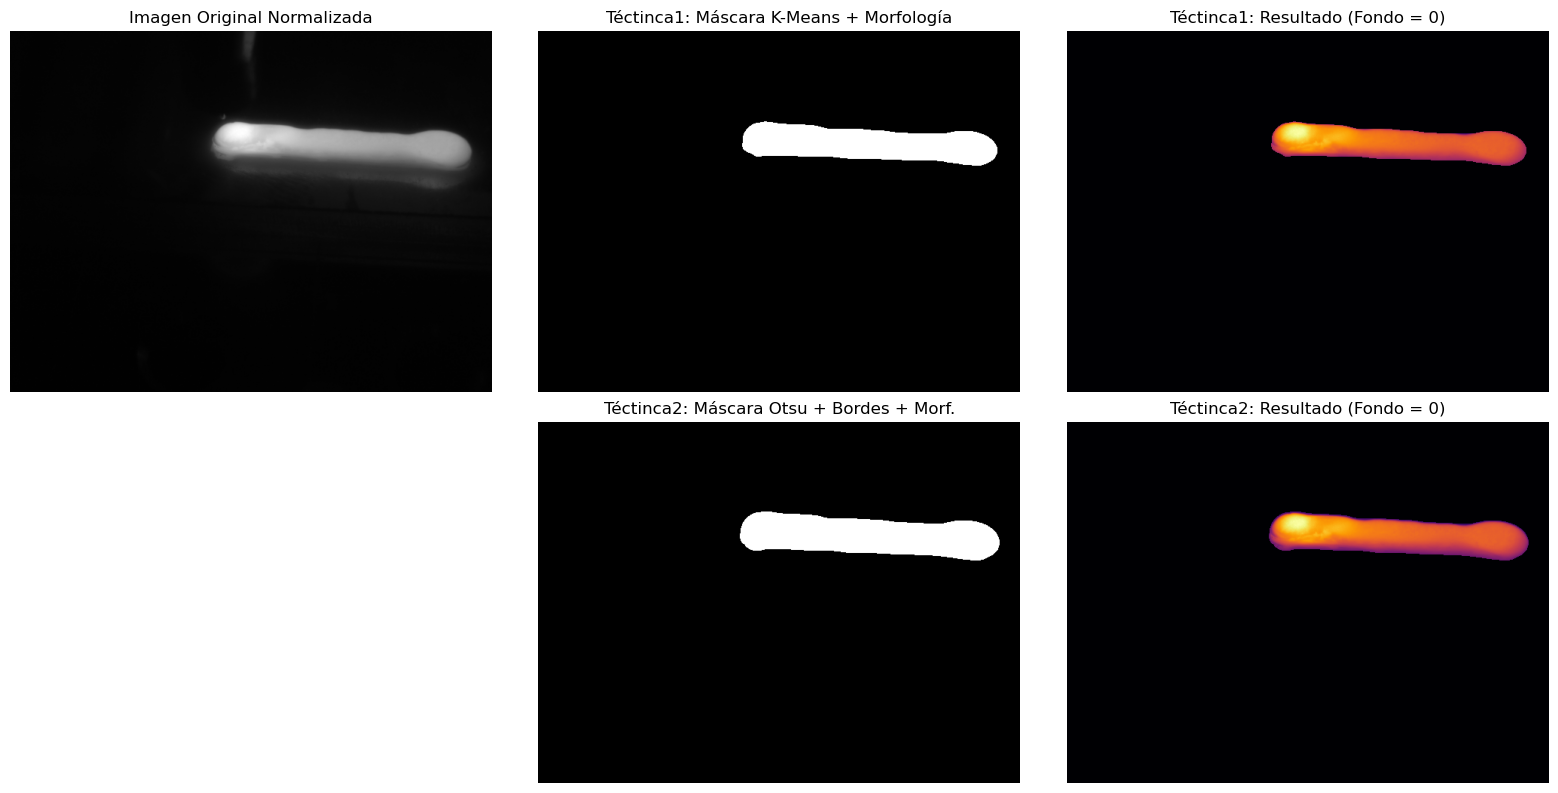

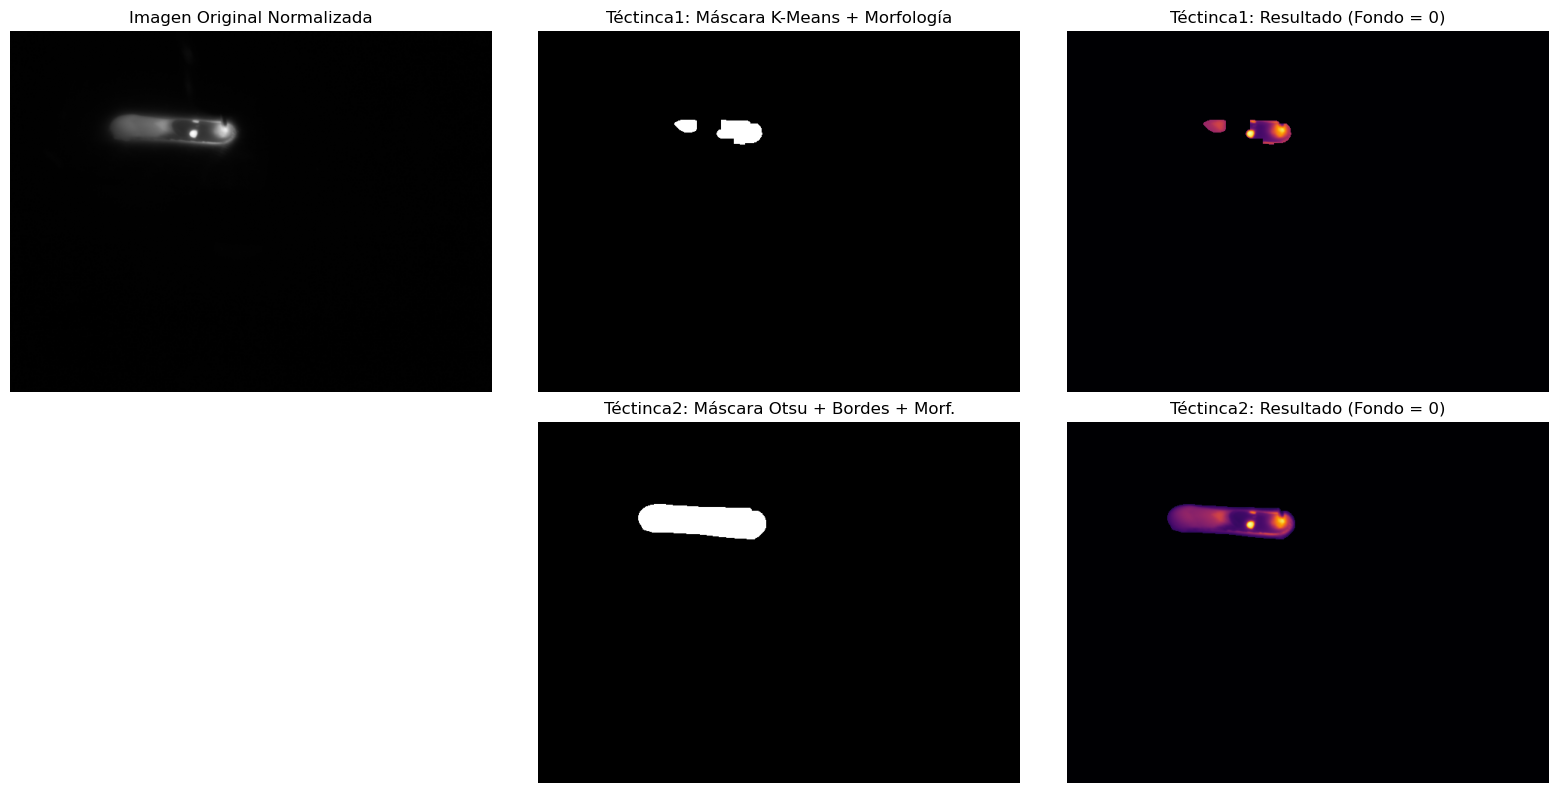

In [ ]:
# --- Ejecución ---
nueva_imagen1 = 'C:/documentos/Dataset/test/1734589662365.tif'
comparar_tecnicas(nueva_imagen1)

nueva_imagen2 = 'C:/documentos/Dataset/test/1734589670381.tif'
comparar_tecnicas(nueva_imagen2)

nueva_imagen3 = 'C:/documentos/Dataset/test/1734589457567.tif'
comparar_tecnicas(nueva_imagen3)

Durante la fase de limpieza, se comprobó que un kernel estándar pequeño es insuficiente para tratar el ruido interno de las imágenes térmicas (como la saturación del sensor o humo). Al trabajar con una ventana de 25 x 25, se logró una dilatación lo suficientemente profunda trabajar con el área de interés. 



Al comparar ambas técnicas de forma secuencial e independiente sobre el conjunto de prueba, la Técnica 2 (Otsu + Gradiente) demostró ser superior en adaptabilidad. Mientras K-Means es un modelo rígido que depende de centroides.